In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


##패션 MNIST 데이터셋 임포트하기

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용하겠습니다. 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냅니다:

여기에서 60,000개의 이미지를 사용하여 네트워크를 훈련하고 10,000개의 이미지를 사용하여 네트워크에서 이미지 분류를 학습한 정도를 평가합니다. TensorFlow에서 직접 Fashion MNIST에 액세스할 수 있습니다. TensorFlow에서 직접 Fashion MNIST 데이터를 가져오고 로드합니다.

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [4]:
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환됩니다:

train_images와 train_labels 배열은 모델 학습에 사용되는 훈련 세트입니다.  
test_images와 test_labels 배열은 모델 테스트에 사용되는 테스트 세트입니다.

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

##데이터 탐색

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
len(train_labels)

60000

In [8]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
len(test_labels)

10000

##데이터 전처리

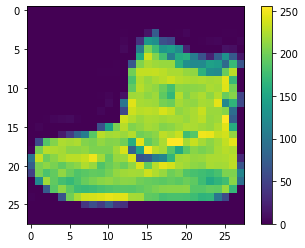

In [12]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정하겠습니다. 이렇게 하려면 255로 나누어야 합니다. 훈련 세트와 테스트 세트를 동일한 방식으로 전처리하는 것이 중요합니다:

In [13]:
train_images = train_images/255.0
test_images = test_images/255.0

훈련 세트에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해 보죠. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

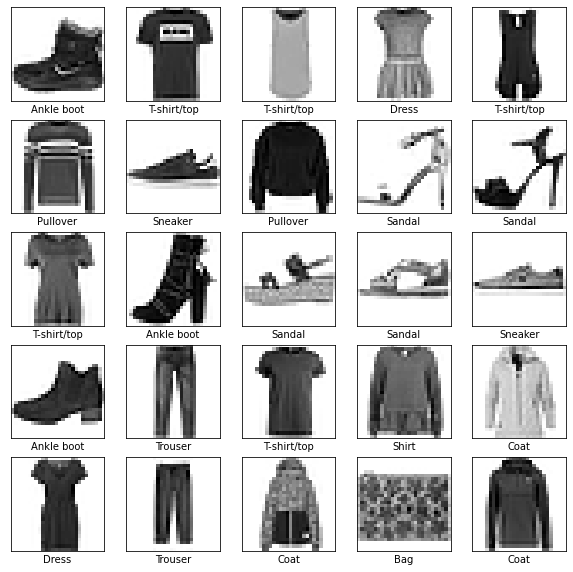

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

##모델 구성

###층 설정

신경망의 기본 빌딩 블록은 레이어 입니다. 레이어는 레이어에 공급된 데이터로부터 표현을 추출합니다. 이러한 표현은 당면한 문제에 의미가 있어야 합니다.

대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

In [19]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(28,28)),
                             tf.keras.layers.Dense(128,activation='relu'),
                             tf.keras.layers.Dense(10)
])

이 네트워크의 첫 번째 층인 tf.keras.layers.Flatten은 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환합니다. 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘립니다. 이 층에는 학습되는 가중치가 없고 데이터를 변환하기만 합니다.

픽셀을 펼친 후에는 두 개의 tf.keras.layers.Dense 층이 연속되어 연결됩니다. 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 두 번째 (마지막) 층은 10개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력합니다.

##모델 컴파일

모델을 훈련할 준비가 되기 전에 몇 가지 설정이 더 필요합니다. 다음은 모델의 컴파일 단계에서 추가됩니다.

손실 함수 - 훈련 중 모델이 얼마나 정확한지 
측정합니다. 모델을 올바른 방향으로 "조정"하려면 이 함수를 최소화해야 합니다.  
옵티마이저 - 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식입니다.  
메트릭 — 훈련 및 테스트 단계를 모니터링하는 데 사용됩니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.

In [21]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

##모델 훈련

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 train_images와 train_labels 배열입니다.  
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.  
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 test_images 배열입니다. 이 예측이 test_labels 배열의 레이블과 맞는지 확인합니다.  
4. 예측이 test_labels 배열의 레이블과 일치하는지 확인합니다.

##모델 피드

훈련을 시작하려면 model.fit 메서드를 호출합니다. 모델을 훈련 데이터에 "맞추기(fit)" 때문에 이렇게 불립니다.

In [22]:
model.fit(train_images,train_labels,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4957 - accuracy: 0.8257
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3726 - accuracy: 0.8644
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3329 - accuracy: 0.8777
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3109 - accuracy: 0.8847
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2943 - accuracy: 0.8906
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2795 - accuracy: 0.8961
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2677 - accuracy: 0.8998
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2568 - accuracy: 0.9043
Epoch 9/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2467 - accuracy: 0.9081
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.239

모델이 훈련되면서 손실과 정확도 지표가 출력됩니다. 이 모델은 훈련 세트에서 약 0.88(88%) 정도의 정확도를 달성합니다.

##정확도 평가

다음으로, 모델이 테스트 데이터세트에서 작동하는 방식을 비교합니다.

In [23]:
test_loss,test_acc = model.evaluate(test_images,test_labels,verbose=2)
print('\nTest accuracy:',test_acc)

313/313 - 1s - loss: 0.3340 - accuracy: 0.8830 - 571ms/epoch - 2ms/step

Test accuracy: 0.8830000162124634


테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮습니다. 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문입니다. 과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상을 말합니다.

##예측하기

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행할 수 있습니다. 모델의 선형 출력, 로짓. 소프트맥스 레이어를 연결하여 로짓을 해석하기 쉬운 확률로 변환합니다.

In [24]:
probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])

In [25]:
predictions = probability_model.predict(test_images)

여기서는 테스트 세트에 있는 각 이미지의 레이블을 예측했습니다. 첫 번째 예측을 확인해 보죠:

In [26]:
predictions[0]

array([2.9232019e-08, 1.4734268e-11, 1.1879508e-08, 2.1666616e-12,
       1.3276168e-10, 1.6643220e-03, 9.7688728e-09, 8.9970892e-03,
       2.0175557e-07, 9.8933828e-01], dtype=float32)

이 예측은 10개의 숫자 배열로 나타납니다. 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냅니다. 가장 높은 신뢰도를 가진 레이블을 찾아보죠:

In [27]:
np.argmax(predictions[0])

9

모델은 이 이미지가 앵클 부츠(class_name[9])라고 가장 확신하고 있습니다. 이 값이 맞는지 테스트 레이블을 확인해 보죠:

In [28]:
test_labels[0]

9

10개 클래스에 대한 예측을 모두 그래프로 표현해 보겠습니다:

In [29]:
def plot_image(i,predictions_array,true_label,img):
    true_label,img = true_label[i],img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img,cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color='blue'
    else:
        color='red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label],
                                         color=color))

In [30]:
def plot_value_array(i, predictions_array,true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10),predictions_array,color='#777777')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

##예측 확인

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행할 수 있습니다.

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인해 보겠습니다.

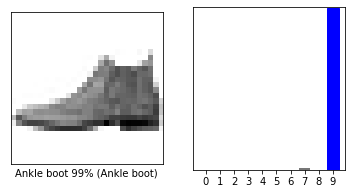

In [32]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i,predictions[i],test_labels,test_images)
plt.subplot(1,2,2)
plot_value_array(i,predictions[i],test_labels)
plt.show()

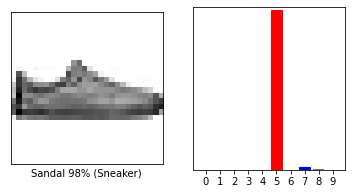

In [33]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i,predictions[i],test_labels,test_images)
plt.subplot(1,2,2)
plot_value_array(i,predictions[i],test_labels)
plt.show()

몇 개의 이미지의 예측을 출력해 보죠. 올바르게 예측된 레이블은 파란색이고 잘못 예측된 레이블은 빨강색입니다. 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)입니다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있습니다.

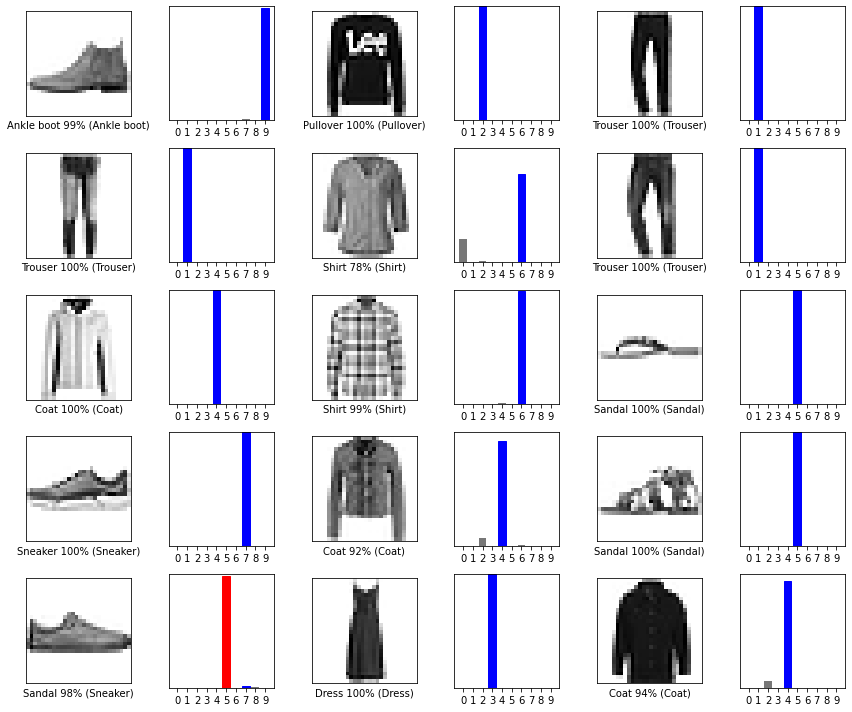

In [35]:
#Plot the first X test images, their predicted labels, and the true labels.
#Color correct predictions in blue and incorrect prediction in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols,2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows,2*num_cols,2*i+1)
    plot_image(i,predictions[i],test_labels,test_images)
    plt.subplot(num_rows,2*num_cols,2*i+2)
    plot_value_array(i,predictions[i],test_labels)
plt.tight_layout()
plt.show()

##훈련된 모델 사용하기

마지막으로 훈련된 모델을 사용하여 한 이미지에 대한 예측을 만듭니다.

In [36]:
#Grad an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


tf.keras 모델은 한 번에 샘플의 묶음 또는 배치(batch)로 예측을 만드는데 최적화되어 있습니다. 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 합니다:

In [37]:
#Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


이제 이 이미지의 예측을 만듭니다:

In [38]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[2.4495626e-05 1.0444568e-13 9.9927241e-01 1.1253301e-09 5.7849335e-04
  5.1600743e-13 1.2466067e-04 4.2266158e-18 3.0773981e-09 8.5840267e-15]]


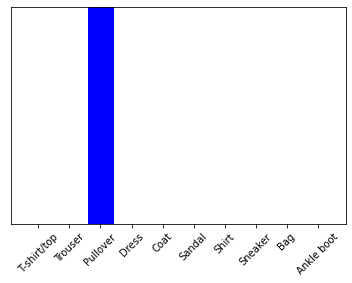

In [45]:
plot_value_array(1, predictions_single[0], test_labels)
_=plt.xticks(range(10), class_names, rotation=45)
plt.show()

tf.keras.Model.predict는 데이터 배치의 각 이미지에 대해 하나의 목록씩 목록의 목록을 반환합니다. 배치에서 (유일한) 이미지에 대한 예측을 가져옵니다.

In [43]:
np.argmax(predictions_single[0])

2

예상과 같이 모델이 레이블을 예측합니다.